# This notebook shows the codes for the "Module extraction", "Module membership analysis" and "Module DE/diagnostic correlation" modules

In [1]:
%pip install -q -r requirements1.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append("../..")
from src.eda.eda_functions import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load outputs from the network analysis module

In [3]:
%%time
tom_df = pd.read_csv('Data/Kapoor_TOM.csv', index_col = 0)

Wall time: 16min 39s


In [6]:
%%time
## load the module assignment by WGCNA
wgcna_modules = pd.read_csv('Data/Module 1-4 outputs/wgcna_modules.csv')

Wall time: 59.6 ms


# Module extraction (by Louvain algorithm) 

In [7]:
%%time
module_df1 = run_louvain(tom_df, 1, -1) # default setting
module_df2 = run_louvain(tom_df, 1, 1) # a different setting for user to test

Wall time: 14min 16s


In [8]:
module_df1.to_csv('Data/Module 1-4 outputs/network_louvain1.csv', index = 0)
module_df2.to_csv('Data/Module 1-4 outputs/network_louvain2.csv', index = 0)

# Module membership analysis 

Removing existing folder: output
Created folder output


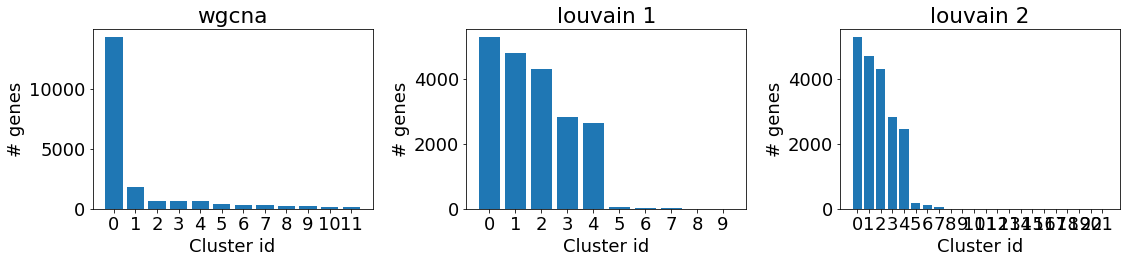

Wall time: 978 ms


In [13]:
%%time
module_dfs = [wgcna_modules, module_df1, module_df2]
module_df_names = ['wgcna','louvain 1', 'louvain 2']
plot_gene_cnt_each_cluster(module_dfs, 'louvain_label', module_df_names)

In [ ]:
## Join expression with subjects' alcohol traits

In [9]:
%%time
# normalized expression data
expression = pd.read_csv('Data/kapoor_expression_Apr5.txt',sep = '\t')
print(expression.head())
# metadata (alcohol traits)
meta = pd.read_csv('Data/kapoor2019_coga.inia.detailed.pheno.04.12.17.csv', low_memory = False)
print(meta.head())
expression_meta = pd.merge(expression, meta, left_index = True, right_on = 'IID')
expression_meta.to_csv('Data/Module 1-4 outputs/expression_meta_Apr6.csv', index = 0)

      ENSG00000227232  ENSG00000237683  ENSG00000241860  ENSG00000228463  \
X214         3.338977         4.307635         1.718635         4.071199   
X460         2.541341         2.229991         0.797516         2.685933   
X584         2.071838         3.249317         0.653183         3.168998   
X551         2.965866         2.268162         1.023589         3.650939   
X530         3.379590         3.717559         1.858563         2.835683   

      ENSG00000225972  ENSG00000225630  ENSG00000237973  ENSG00000229344  \
X214         5.493089         7.081400         9.131822         6.364326   
X460         6.076272         8.253067         9.791742         6.575031   
X584         5.428418         7.249520         8.760305         6.017873   
X551         6.999395         8.737079         9.992433         7.467388   
X530         6.411183         8.400833         9.409261         7.082551   

      ENSG00000248527  ENSG00000198744  ...  ENSG00000226555  ENSG00000176728  \
X214 

In [8]:
expression_meta.head()

,ENSG00000227232,ENSG00000237683,ENSG00000241860,ENSG00000228463,ENSG00000225972,ENSG00000225630,ENSG00000237973,ENSG00000229344,ENSG00000248527,ENSG00000198744,...,Agonal_phase,Liver_class,Smoking_frequency,Pack_yrs_1_pktperday_1_yr,AUDIT,Alcohol_intake_gmsperday,Total_drinking_yrs,Depression,Anxiety,SR
0,3.133118,3.823457,1.022690,4.174664,4.721111,6.249569,10.326613,5.613722,7.627960,6.452445,...,Rapid,Steatosis,99 - Not reported,NaN,186.0,266.0,23.0,Yes,No,1
1,2.389945,1.997970,0.368830,3.233721,5.096691,7.036703,11.125171,5.548298,7.972209,6.557081,...,Rapid,Normal,99 - Not reported,NaN,NaN,NaN,NaN,No,No,2
2,1.877375,2.878354,0.028265,3.250095,4.613348,6.347241,10.051990,5.206124,7.612012,6.188654,...,Rapid,Normal,01 - Everyday/7days per week,42.0,42.0,102.0,27.0,Yes,No,3
3,2.657129,1.632495,0.247083,4.155158,5.912895,7.480004,11.234187,6.384119,8.501137,6.789110,...,Intermediate,Steatosis,99 - Not reported,NaN,0.0,0.0,NaN,No,No,4
4,3.186562,3.185500,1.100501,2.999840,5.616984,7.564768,10.804071,6.327458,8.428120,7.109489,...,Rapid,Normal,01 - Everyday/7days per week,38.0,56.0,136.0,31.0,Yes,No,5


## Determine network stability

In [14]:
%%time
cluster_pair_wgcna_n_com1, network_cluster_stability1 = network_cluster_stability(wgcna_modules, module_df1, 'louvain_label', expression_meta)

Wall time: 6min 48s


### The histograms below show distribution for z scores for p value or correlation coefficient if the cluster membership is randomly assigned. The red vertical line is where the actual Z score is. For p value, the red line should be as left as possible for small p values for the actual cluster, meaning it's very unlikely that the module membership is randomly assigned. For correlation coefficient, a very left or very right red veritcal line is good, meaning there is a strong (positive or negative) correlation between the two clusters)

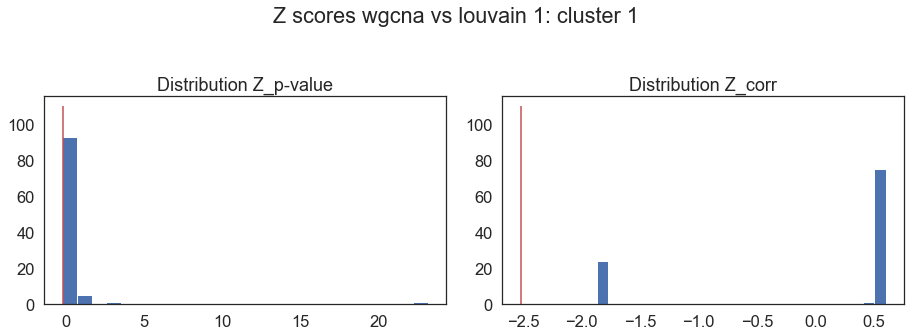

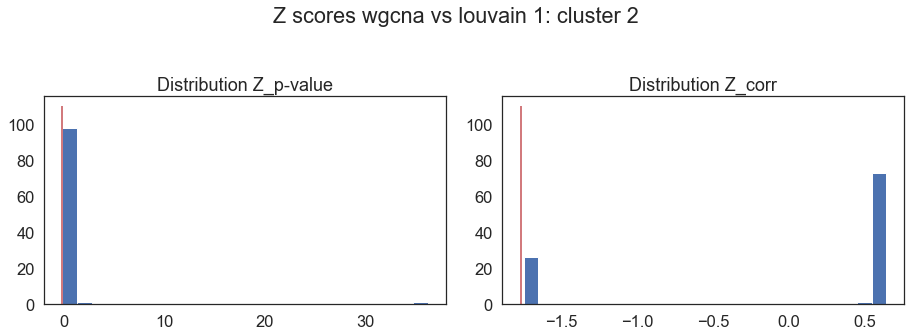

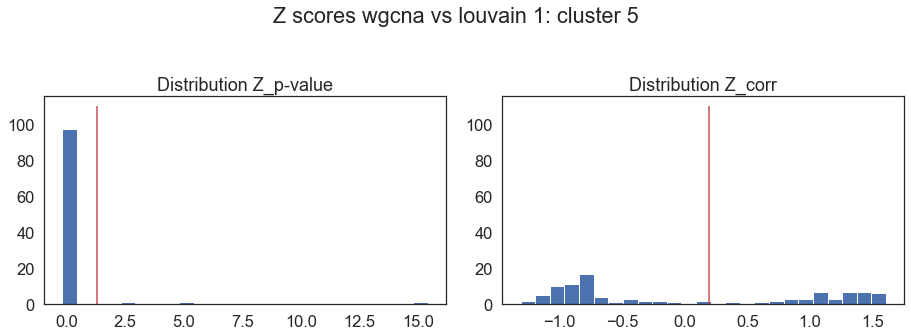

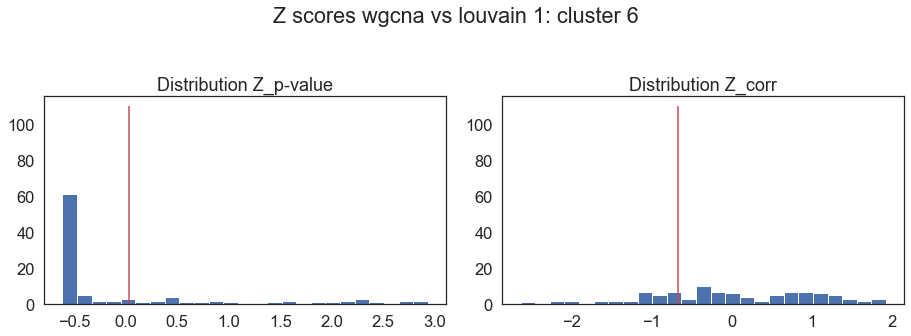

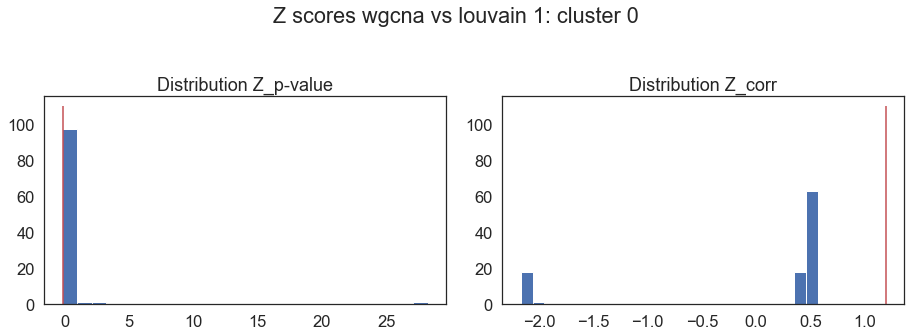

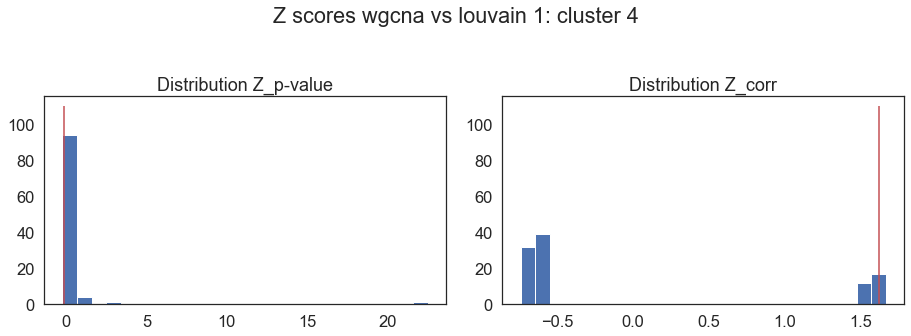

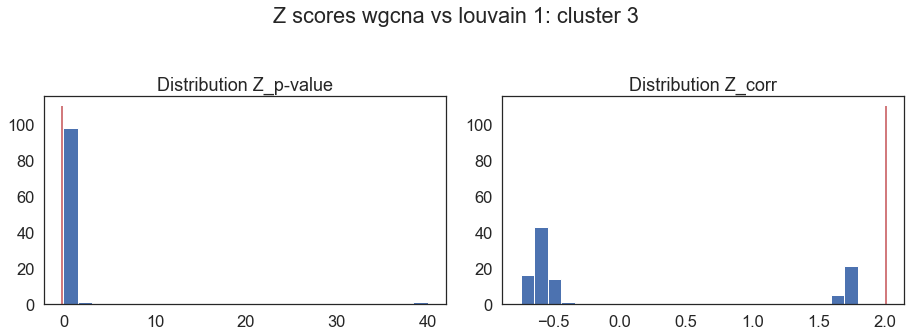

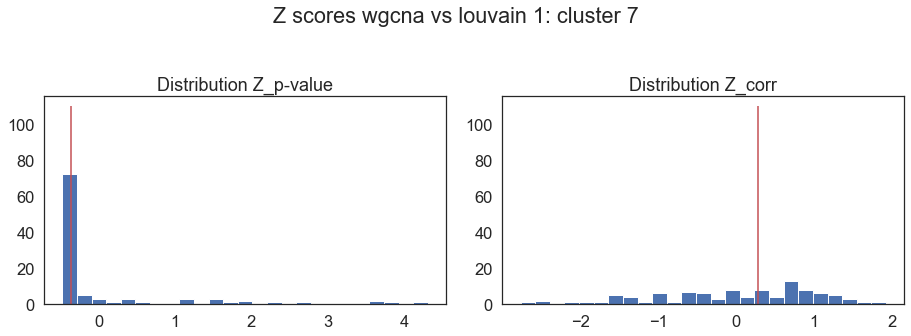

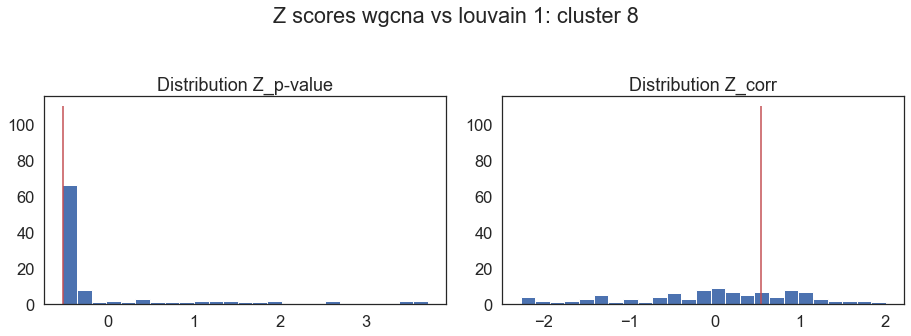

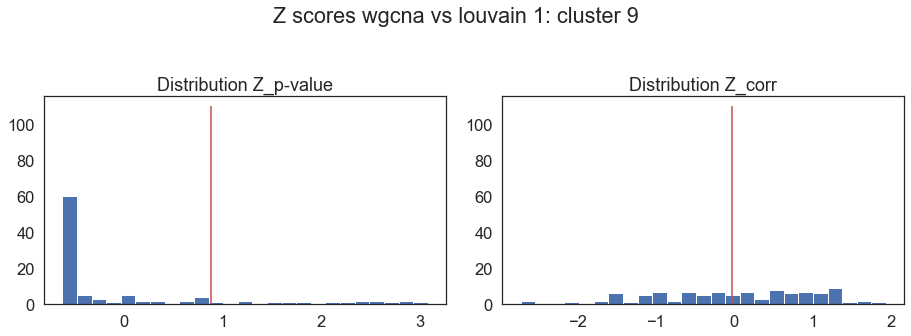

Wall time: 5min 27s


In [22]:
%%time
for cluster in module_df1.louvain_label.unique():
    plot_random_vs_actual_z(wgcna_modules, module_df1, cluster_pair_wgcna_n_com1[cluster], cluster, 'louvain_label', network_cluster_stability1, 'wgcna vs louvain 1', expression_meta)

# Module DE/ diagnostic correlation

In [11]:
# use deseq data to examine DEG and module correlation
deseq = pd.read_excel('Data/deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')
deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])

In [16]:
module_dfs = [wgcna_modules, module_df1, module_df2]
module_df_names = ['wgcna','louvain 1', 'louvain 2']

## Method 1: DEGs per module for 3 types of module assignment

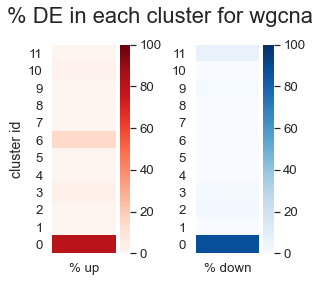

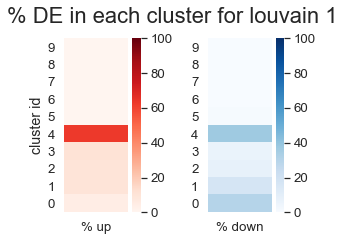

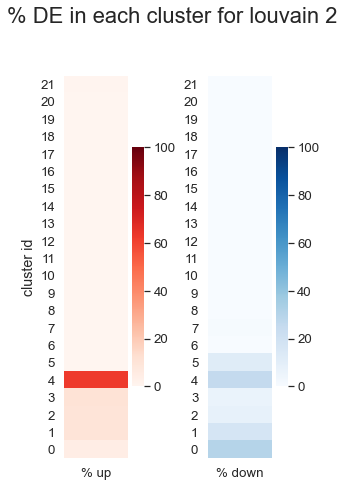

Wall time: 2.92 s


In [17]:
%%time
for module_df, name in zip(module_dfs, module_df_names):
    cluster_DE_perc(module_df, 'louvain_label', name, deseq)

### Louvain 1 module assignment will be used for downstream analysis as it aggregates DEGs into a single module effectively. WGCNA seems to be doing that but if you look at the bar plots under "Module membership analysis", WGCNA does that by putting all the nodes in cluster 0 so it is not really aggregating DEGs but just putting all the nodes in 1 module. 

## Method 2: Percentage of significant genes for each module for 3 types of module assignment

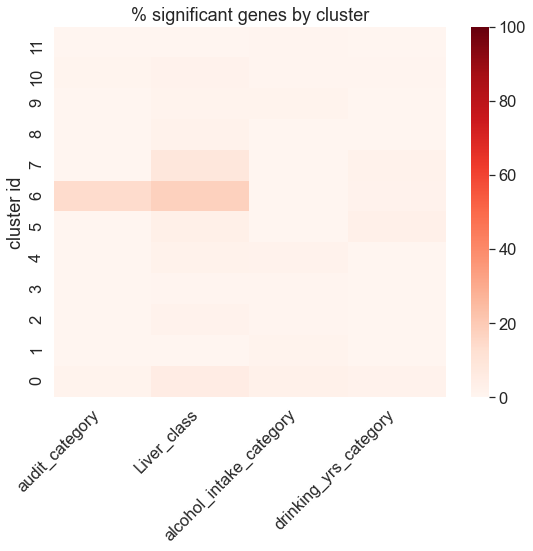

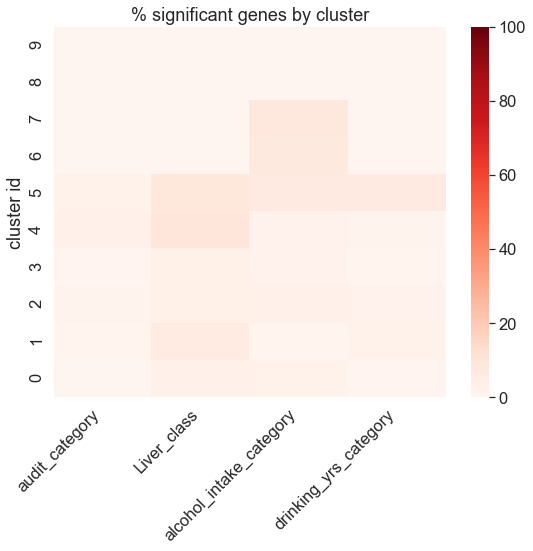

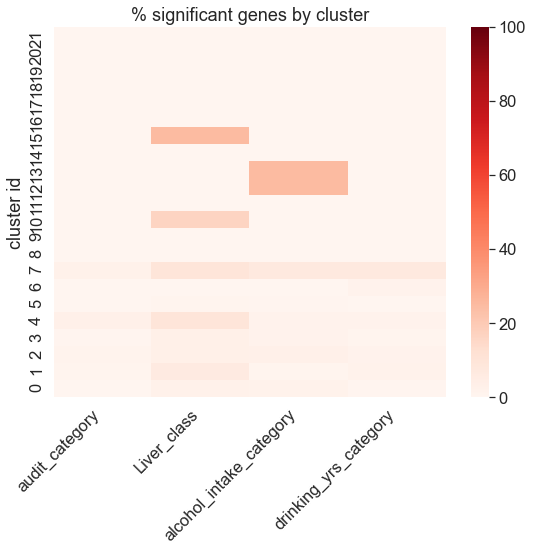

Wall time: 26min 27s


In [18]:
%%time
for module_df, name in zip(module_dfs, module_df_names):
    plot_sig_perc(module_df, 'louvain_label', name, expression_meta)

## Method 3: Module eigengene and alcohol trait correlation for 3 types of module assignment

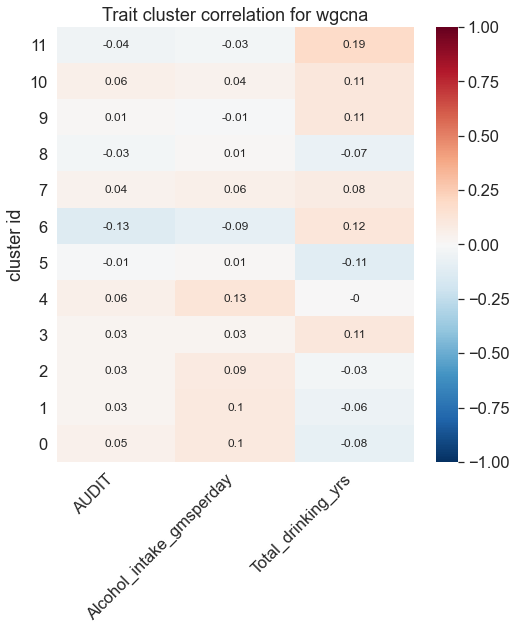

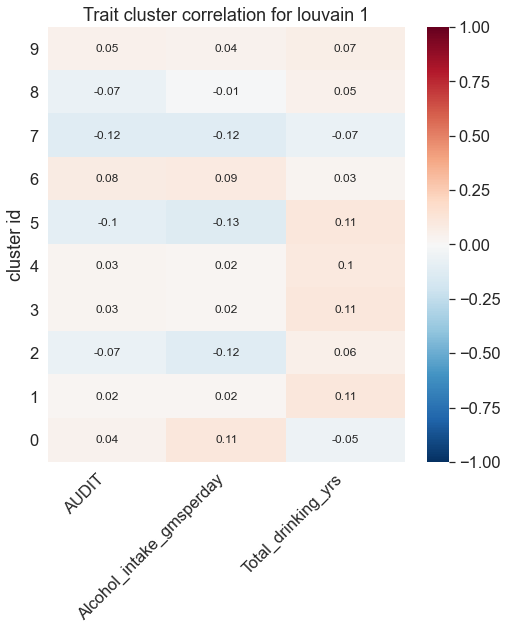

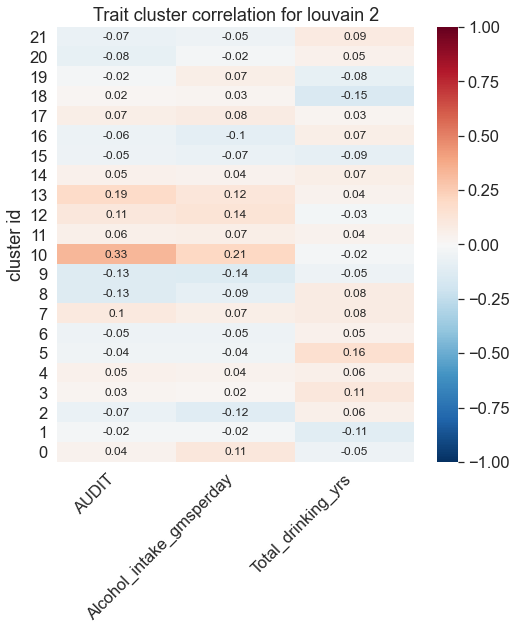

Wall time: 14.7 s


In [19]:
%%time
for module_df, name in zip(module_dfs, module_df_names):
    cluster_phenotype_corr(module_df, 'louvain_label', name, expression_meta)